In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os

In [3]:
def rgb2gray(rgb):
    """
    grayscale = 0.299*red + 0.587*green + 0.114*blue
    """
    return np.dot(rgb[...,:3],[0.299,0.587,0.114])

In [4]:
#load the cifar10 data
(x_train,_),(x_test,_) = cifar10.load_data()

170508288/170498071 [==============================] - 21s 0us/step


In [5]:
#input image dimensions
#we assume data format 'channels_last'
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [7]:
#create saved_image folder

imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(),imgs_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

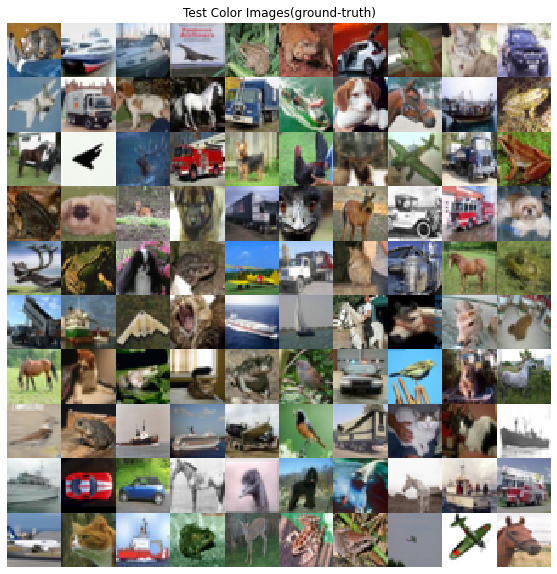

In [14]:
#display the 1st 100 input images(color and gray)

imgs = x_test[:100]
imgs = imgs.reshape((10,10,img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(15, 10))
plt.axis('off')
plt.title('Test Color Images(ground-truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png'% imgs_dir)
plt.show()

In [9]:
#convert color train and test images to gray

x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

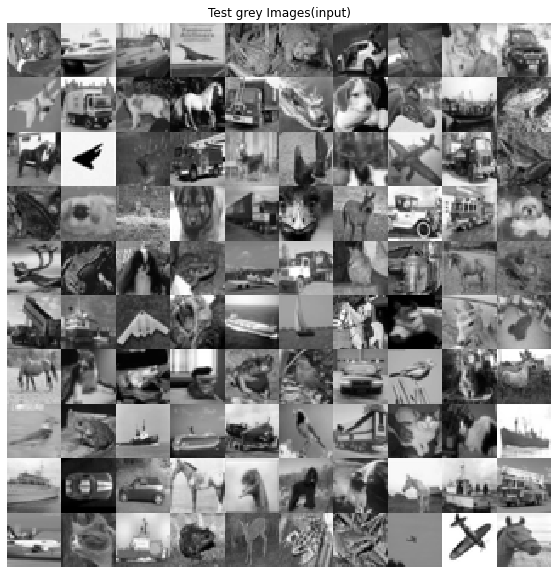

In [15]:
#display grayscale version of test images

imgs = x_test_gray[:100]
imgs = imgs.reshape((10,10,img_rows,img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Test grey Images(input)')
plt.imshow(imgs, interpolation='none',cmap='gray')
plt.savefig('%s/test_gray.png'%imgs_dir)
plt.show()

In [16]:
#normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [17]:
#normalizse input train and test grayscale images 
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [18]:
#reshape images to row x col x chaneel for CNN output/validation

x_train = x_train.reshape(x_train.shape[0],img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

In [19]:
#reshae images to row x col x channel for CNN input 

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols,1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0],img_rows, img_cols, 1)


In [20]:
#network parameters

input_shape = (img_rows, img_cols, 1)
batch_size = 32 
kernel_size = 3
latent_dim = 256

#encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [21]:
#build the autoencoder model 

#first the encoder part 

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs 

#stack of Conv2D(64)-Conv2d(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=2,
              activation='relu',
              padding='same')(x)

In [22]:
#shape info needed to build decoder model so we dont do hand computation 
#the input to the decoder's first conv2DTranspose will have this shape. 
#shape in (4,4,256) which is processed by the decoder back to (32, 32, 3)

shape = K.int_shape(x)

In [23]:
#generate a latent vector

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [24]:
#instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

In [25]:
#build the decoder part 

latent_inputs = Input(shape=(latent_dim,),name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2],shape[3]))(x)

In [26]:
#stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       activation='relu',
                       padding='same')(x)

In [27]:
outputs = Conv2DTranspose(filters=channels,
                         kernel_size=kernel_size,
                         activation='sigmoid',
                         padding='same',
                         name='decoder_output')(x)

In [28]:
#instantiate the decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

In [29]:
#autoencoder = encoder + decoder
#instantiate autoencoder model 

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [30]:
#prepare model saving directory 

save_dir = os.path.join(os.getcwd(),'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

filepath = os.path.join(save_dir, model_name)

In [31]:
#reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs

lr_reduce = ReduceLROnPlateau(factor=np.sqrt(0.1),
                             cooldown=0,
                             patience=5,
                             verbose=1,
                             min_lr=0.5e-6)

In [32]:
#save weights for future use(e.g reload paramters without training)

checkpoint = ModelCheckpoint(filepath=filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True)

In [33]:
#Mean square error(MSE) Loss function and Adam Optimizer 

autoencoder.compile(loss='mse',optimizer='adam')

In [34]:
#called very epoch
callbacks = [lr_reduce, checkpoint]

In [35]:
#train the autoencoder
autoencoder.fit(x_train_gray,
               x_train,
               validation_data=(x_test_gray,x_test),
               epochs=30,
               batch_size = batch_size,
               callbacks= callbacks)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0155
Epoch 1: val_loss improved from inf to 0.01134, saving model to C:\Users\konar\OneDrive\Documents\op_cv_deep\saved_models\colorized_ae_model.001.h5
1563/1563 [==============================] - 194s 124ms/step - loss: 0.0155 - val_loss: 0.0113 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0102
Epoch 2: val_loss improved from 0.01134 to 0.00975, saving model to C:\Users\konar\OneDrive\Documents\op_cv_deep\saved_models\colorized_ae_model.002.h5
1563/1563 [==============================] - 275s 176ms/step - loss: 0.0102 - val_loss: 0.0097 - lr: 0.0010
Epoch 3/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0092
Epoch 3: val_loss improved from 0.00975 to 0.00894, saving model to C:\Users\konar\OneDrive\Documents\op_cv_deep\saved_models\colorized_ae_model.003.h5
1563/1563 [==============================] - 275s 176ms/step - loss: 0.0092 - val_loss: 0.0089 

1563/1563 [==============================] - ETA: 0s - loss: 0.0036
Epoch 30: val_loss did not improve from 0.00759
1563/1563 [==============================] - 252s 161ms/step - loss: 0.0036 - val_loss: 0.0079 - lr: 3.1623e-05


In [36]:
#predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

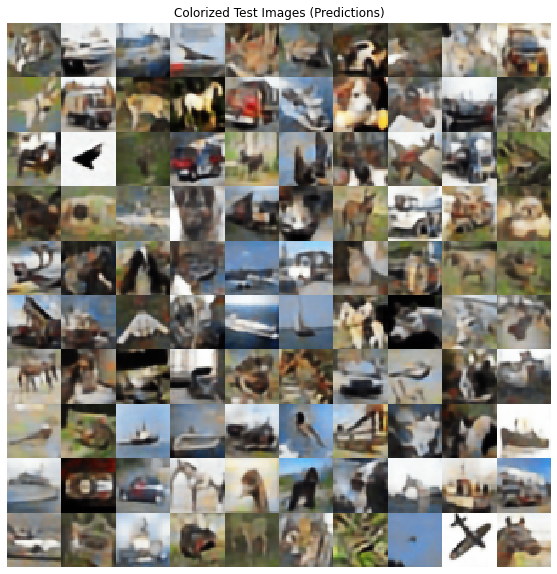

In [38]:
#display the first 100 colorize images 

imgs = x_decoded[:100]
imgs = imgs.reshape((10,10,img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Colorized Test Images (Predictions)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%scolorized.png'%imgs_dir)
plt.show()